# Nonlinear Regression

## Description:

The core function of this code is my_regression(trainX, testX, noutputs) which has the following ins/outs:

Inputs:

trainX - Used for TRAINING and VALIDATION, an \[ntrain x (nfeatures + noutputs)\] array that contains the outputs in the last 'noutputs' columns and the features in the remaining first 'nfeatures' columns;

testX - Used for TESTING, an \[ntest x nfeatures\] array of test data for which the predictions for output Y are made;

noutputs - the number of output columns in trainX;

Outputs:

predictestY - \[ntest x noutputs\] array, which contains the prediction values testY for the testing data testX. These computed data can be used to then calculate squared error by comparing against the testX outputs found in the dataset.

A regression model that best fits the datasets is developed. All data sets are curated from the UCI Machine Learning repository:

Airfoil Self-Noise (has 1 output variable): https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise

Yacht Hydrodynamics (has 1 output variable): https://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics

Concrete Slump (has 3 output variables): https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test



## Question 1:

def my_regression(trainX, testX, noutputs) is developed with the following characteristics:

The code performs K-fold cross-validation to determine the right model $w$ for the training data, comparing the mean squared error (MSE) of the testing set outputs for multiple values of regularization parameter $\lambda$ (0 to 10) and under various basis functions $\phi$ (linear, polynomial, gaussian). This model is applied to the test data to make a prediction that should damp the noise effect in the data. The code trains/validates the model using only trainX then tests the model using testX. It does not use any regression library, but uses NumPy for array operations and scikit-learn to generate a polynomial basis of order M=2.

Note that the code performs z-score data standardization by scaling each feature/column to the interval \[0,1\] (using $(x_{(each\ i),j}-\mu_j)/\sigma_j$), runs K-fold cross-validation on the training/validation data, and programmatically selects the best basis function with the corresponding regularization parameter and model that generate the lowest mean squared error on the testing data. It can use any basis functions as defined in a separate method.

To check the code's validity, the reader should uncomment the "print" blocs inside the code that are of interest to them. This will display the values of the computed variables as the code runs.

In [1]:
# use numpy
import numpy as np
# use scikit-Learn / PolynomialFeatures for Polynomial Basis Functions
# use scikit-Learn / scale for standardizing data X
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
# use random to choose indices for testing data
import random
# use matplotlib to plot figures
import matplotlib.pyplot as plt
# clear cell output
from IPython.display import clear_output


In [2]:
def phi_gen_basis(X, basisName):
    # genetrate Phi(X) in basis basisName
    (ndata,nfeatures) = X.shape
    Phi0      = np.ones((ndata,1))
    if basisName == 'linear':
        # generates linear basis functions Phi(X)
        # concatenate 2 numpy arrays: column-wise by specifying axis=1
        # note that in the below case: Phi is constructed by concatenating 
        # single column of 1's to array X, hence number of columns of Phi is (o+1)
        Phi = np.concatenate((Phi0,X),axis=1)
        return Phi
        #
    elif basisName == 'polynomial':
        # generates polynomial basis functions Phi(X)
        # for simplicity: polynomial with specific degree M is selected
        # use of PolynomialFeatures from sklearn
        # For example, if an input sample is 2-D of the form X = [a, b], where 
        # a,b are 1-D vectors then the degree-2 polynomial features are [1, a, b, a^2, ab, b^2]
        # desired degree of polynomial
        M    = 2
        poly = PolynomialFeatures(M)
        Phi  = poly.fit_transform(X)
        return Phi
        #
    elif basisName == 'gaussian':
        # generates Gaussian radial basis functions Phi(X)
        # z-score: standardizing X around means muj and st-devs sj
        # scale computes (xj-muj)/sj
        # option 'axis' chooses axis used to compute the means and standard deviations along. 
        # axis = 0 by default: column-wise, i.e. independently standardize each feature / dimension.
        Xstandard = scale(X)
        # this will compute exp( -1/2 * ((xj-muj)/sj)^2 )
        PhiExp    = np.exp((-1/2) * np.power(Xstandard,2))
        # concatenate 2 numpy arrays: column-wise by specifying axis=1
        # note that in the below case: Phi is constructed by concatenating 
        # single column of 1's to array X, hence number of columns of Phi is (o+1)
        Phi       = np.concatenate((Phi0,PhiExp),axis=1)
        # vector or 1's needed???????????????????????????????????????
        return Phi
        #
    else:
        print('Error! basis name should be one of the following: \'linear\' \'polynomial\' \'gaussian\'')
        Phi = np.zeros(1,1)
        return Phi



def estimate_model(Ttrain,Phi,lambda_reg):
    # estimate model, i.e. regression coefficients w
    # warning: for arrays, use np.dot() and np.add() methods. Do NOT use * or +
    # calculate the 'λ-regularized' pseudo-inverse Phi_plus multiplied by outputs Ttrain
    # Phi_plus   * Ttrain = (Phi' * Phi + λ * I)^-1 * Phi'   * Ttrain
    # note that dimensions of Phi_plus = dimensions of Phi transpose
    # Identity array has same dimension as number of COLUMNS in Phi (i.e. number of BASIS FUNCTIONS)            
    # w is the vector of regression coefficients
    # one column wj of w is generated by Ttrain[:,j]
    # Phi transpose
    Phitranspose = np.matrix.transpose(Phi)
    # Identity matrix; no penalty added to intercept
    Identity = np.identity(len(Phi[0,:]))
    Identity[0,0] = 0
    # estimate model, i.e. regression coefficients w_ML
    w = np.dot(np.linalg.inv(np.add(np.dot(Phitranspose,Phi),lambda_reg*Identity)),np.dot(Phitranspose,Ttrain))
    return w



def Kfold_cross_validation(Xtrainval,Ttrainval,noutputs,K,lambda_reg,basisName):
    # perform regression analysis with K-fold cross-validation on trainig/validation dataset Xtrainval
    # split array Xtrainval to K folds of size n each (last fold will have size <= n)
    (ndata,nfeatures) = Xtrainval.shape
    n                 = np.ceil(ndata / K).astype('int')
    # use n to yield K 'n-sized' folds from array Xtrainval
    MSEval     = np.zeros((K,noutputs))
    # at each iteration, ONLY k^th array is for validating and ALL OTHER arrays for training
    k = 0
    # perform K-fold cross-validation
    for i in range(0, ndata, n):
        # ONLY k^th array for validating
        Xval   = Xtrainval[i:i + n]
        Tval   = Ttrainval[i:i + n]
        # ALL OTHER arrays for training: concatenate row-wise by specifying axis=0
        Xtrain = np.concatenate((Xtrainval[:i],Xtrainval[i + n:]))
        Ttrain = np.concatenate((Ttrainval[:i],Ttrainval[i + n:]))
        # use regression on TRAINING set (Xtrain,Train)
        # generate basis functions: this projects training data Xtrain onto basis Phi --> Phi(Xtrain)
        Phi          = phi_gen_basis(Xtrain,basisName)
        w            = estimate_model(Ttrain,Phi,lambda_reg)
        # predictrainY the predicted output
        predictrainY = Phi.dot(w)
        # now apply model (Basis Phi, Regression Coefficients w) to validation data Xval
        # generate basis functions: keep same training basis
        # this projects validation data Xval onto basis Phi --> Phi(Xval)
        Phi_val      = phi_gen_basis(Xval,basisName)
        # predicvalY the predicted output
        predicvalY   = Phi_val.dot(w)
        #
        # MSEval[k] mean squared error between each measured output t=Tval and each predicted output predicvalY
        # square all, then compute mean (sum and divide by number of samples)
        MSEval[k,:]  = np.mean((np.power((Tval - predicvalY), 2)), axis=0) # column-wise: axis=0
        #
        """
        print('***************************************************')
        print('Training in all folds except validation fold k =\n',k)
        print('MSE when k^th fold is for validation MSEval[k,:] =\n', MSEval[k,:])
        print('***************************************************')
        # wait for keypress
        # input("Press Enter to continue...")
        """
        k = k+1
    # MSEval[k,:] will be meaned (summed up and divided by number of samples) to obtain MSEval
    # compute mean (sum and divide by number of samples)
    MSEvallambda = np.mean(MSEval, axis=0) # column-wise: axis=0
    # returns the mean of computed MSEs
    return MSEvallambda



def select_lambda(Xtrainval,Ttrainval,noutputs,basisName):
    # set values for regularisation parameter lambda_reg (λ)
    # Create empty dictionary to record lambda as key, corresponding ARRAY MSEvallambda as value
    MSEvalDict   = {}
    lambdaValues = [0, 0.1, 0.3, 0.5, 1, 3, 5, 10]
    for lambda_reg in lambdaValues:
        # select best regularization parameter λ* by looping over various values for lambda_reg
        # perform K-fold cross validation for each lambda
        K            = 5
        # returns the mean of computed MSEs
        MSEvallambda = Kfold_cross_validation(Xtrainval,Ttrainval,noutputs,K,lambda_reg,basisName)
        # Adding MSEvallambda list as value to dictionary
        MSEvalDict[lambda_reg] = MSEvallambda
    #
    # Select λ* as the one with the minimum (CV error)(λ) MSEvallambda
    # i.e. Pick the model (Basis Phi, Regression Coefficients w) along with
    # regulariser value lambda_reg (λ) that produce the lowest validation MSEval
    # since MSEvallambda may be for mutliple outputs, WHICH ARE STANDARDIZED (before my_Regression function call)
    # then we can sum all elements of MSEvallambda for each lambda and choose the lowest one
    key_min      = min(MSEvalDict.keys(), key=(lambda lambda_reg: np.sum(MSEvalDict[lambda_reg])))
    # best λ
    lambda_best  = key_min
    # best validation MSE
    MSEval_best  = MSEvalDict[lambda_best]
    print('***************************************************')
    print('Basis Name: ',basisName)
    print('Lambda for Minimum Value of MSEvallambda: ',lambda_best)
    print('Corresponding Minimum Value of MSEvallambda: ',MSEval_best)
    print('All Recordings for lambda and MSE validation errors MSEvalDict =\n', MSEvalDict)
    print('***************************************************')
    # wait for keypress
    # input("Press Enter to continue...")
    return lambda_best, MSEval_best, MSEvalDict



def my_regression(trainX, testX, noutputs):
    """
    Inputs:
      trainX   - ****** USED FOR TRAINING AND VALIDATION ******
                 an [ntrain x (nfeatures + noutputs)] array that contains the features in the first 'nfeature' columns and
                 the outputs in the last 'noutput' columns
      testX    - ****** USED FOR TESTING ******
                 an [ntest x nfeatures] array of test data for which the predictions are made
      noutputs -
                 number of output columns in trainX
    Outputs:
      predictestY  - [ntest x noutputs] array, which contains the prediction values Y for the testX data. 
                 These data can be used to then calculate squared error by comparing against the testX outputs.
    """
    #
    # last 'noutputs' columns of trainX are for TRAINING AND VALIDATION outputs / measurements Tdata
    Tdata          = trainX[:,-noutputs:]
    # remaining columns of trainX are for TRAINING AND VALIDATION features Xdata
    Xdata          = trainX[:,:-noutputs]
    (ntrain,nfeatures) = Xdata.shape
    # all columns of testX are for TESTING features testX
    (ntest,nfeatval)   = testX.shape
    # Check length of features in Xdata and testX
    if nfeatures != nfeatval:
        return 'Error! length of features in training/testing and validation sets must agree!'
    #
    # z-score: STANDARDIZATION SHOULD BE DONE ON ENTIRE SET (TRAINING/VALIDATION AND TESTING)
    # it is done before/outside each my_Regression function call
    # standardize training/validation features Xdata, outputs Tdata, testing features testX
    # by subtracting by the mean of each column of the data and 
    # dividing by the standard deviation of each column of the data
    # resulting sets will have columns with means of 0 and st-devs of 1
    # z-score: standardized Tdata
    Ttrainval = Tdata # scale(Tdata)
    # z-score: standardized Xdata
    Xtrainval = Xdata # scale(Xdata)
    # z-score: standardized testX
    Xtest     = testX # scale(testX)
    #
    # regression analysis with K-fold cross validation on dataset Xtrainval
    # loop over basis functions, then loop over lambda values
    #
    # Create empty dictionaries to record basisName as key, corresponding best lambda λ and best validation MSEval as value
    lambdabestDict  = {}
    MSEvalbestDict  = {}
    # Create empty nested dictionary to record basisName as key1, with all corresponding λ as key2, and MSEval as values
    MSEvalDict  = {'linear':{}, 'polynomial':{}, 'gaussian':{}}
    # basisName is used to generate basis functions: choose from 'linear' 'polynomial' 'gaussian'
    basisNames = ['linear', 'polynomial', 'gaussian']
    for basisName in basisNames:
        # best λ
        lambdabestDict[basisName], MSEvalbestDict[basisName], MSEvalDict[basisName] = \
                                                                    select_lambda(Xtrainval,Ttrainval,noutputs,basisName)
    """
    print('***************************************************')
    print('Recorded values for basis names and best lambda:\n')
    print('lambdabestDict =\n', lambdabestDict)
    print('MSEvalbestDict =\n', MSEvalbestDict)
    print('MSEvalDict =\n', MSEvalDict)
    print('***************************************************')
    # wait for keypress
    # input("Press Enter to continue...")
    """
    # Select best basis as the one whose lambda produced the minimum (CV error)(λ) (MSEvallambda which is a sum)
    key_min      = min(lambdabestDict.keys(), key=(lambda basisName: np.sum(MSEvalbestDict[basisName])))
    # best basis, λ, validation error MSEval
    basis_best   = key_min
    lambda_best  = lambdabestDict[basis_best]
    MSEval_best  = MSEvalbestDict[basis_best]
    print('***************************************************')
    print('Basis for Best Value of Lambda = ',basis_best)
    print('Corresponding Best Value of Lambda = ',lambda_best)
    print('Corresponding Minimum Value of MSEvallambda = ',MSEval_best)
    print('Entire recordings (basis functions, lambda values, validation MSE) MSEvalDict =\n',MSEvalDict)
    print('***************************************************')
    # wait for keypress
    # input("Press Enter to continue...")
    #
    # Compute the chosen model y(λ) on the entire training set Xtrainval:
    # generate basis functions: 
    # this projects training data Xtrainval onto basis Phi --> Phi(Xtrainval)
    Phi          = phi_gen_basis(Xtrainval,basis_best)
    w            = estimate_model(Ttrainval,Phi,lambda_best)
    #
    # Apply y(λ) to the test set to assess test error
    # generate basis functions: this projects training data Xtest onto basis Phi --> Phi(Xtest)
    Phi          = phi_gen_basis(Xtest,basis_best)
    # predictestY the predicted output
    predictestY  = Phi.dot(w)
    print('***************************************************')
    print('Predicted outputs Y (for testX) predictestY =\n',predictestY)
    print('***************************************************')
    # wait for keypress
    # input("Press Enter to continue...")
    return predictestY


## Question 2:

The code is tested on a simple one-dimensional data set, where the training/validation and testing features are $x \in [-5,5]$, and the training/validation data outputs are generated by the function $t = y + \epsilon$ where $y = \cos (x^2) + 0.1 x^3$ is the true model output and $\epsilon = N(0,\sigma^2)$ is additive white Gaussian noise of mean 0 and variance $\sigma^2$.

In [3]:
def question2(ndataValues,sigmaValues):
    # this function answers question 2
    # ndata is the number of all datapoints (training/validation and testing)
    # for noise, 0 is the mean of the normal distribution we are choosing from
    # and sigma (σ) is the standard deviation of this normal distribution
    # number of outputs T is 1
    # number of features X is also 1
    noutputs = 1;
    # returns MSE for prediction testY of testing data testX
    MSEtestY = np.ones((len(ndataValues), len(sigmaValues), noutputs))
    for i in range(0,len(ndataValues)):
        for j in range(0,len(sigmaValues)):
            ndata    = ndataValues[i]
            sigma    = sigmaValues[j]
            X        = np.linspace(-5,+5,ndata)
            X        = np.transpose([X])
            noise    = np.random.normal(0,sigma,ndata)
            noise    = np.transpose([noise])
            Y        = np.add(np.cos(np.power(X,2)), 0.1*np.power(X,3))
            T        = Y + noise
            #
            # z-score: STANDARDIZATION SHOULD BE DONE ON ENTIRE SET (TRAINING/VALIDATION U TESTING)
            # STANDARDIZATION is done before/outside each my_Regression function call
            # standardize training/validation features Xdata, outputs Tdata, testing features testX
            # by subtracting by the mean of each column of the data and 
            # dividing by the standard deviation of each column of the data
            # resulting sets will have columns with means of 0 and st-devs of 1
            X = scale(X)
            Y = scale(Y)
            T = scale(T)
            #
            # testX and trainX should be selected carefully to avoid getting non-representative samples
            # RANDOMLY select 20% of data for testing (in testX) and 80% of data for training/validation (in trainX)
            (ndata,c) = X.shape
            ntest     = np.ceil(20/100*ndata).astype('int')
            # for sampling without duplicates, use random.sample; to choose with replacement, use random.choices
            data_idx  = range(0,ndata)
            testX_idx = random.sample(data_idx, k=ntest)
            testX_idx.sort()
            # Use 'set' to remove elements of one list from another; it has the fastest performance
            # however, note that 'set' removes duplicates and doesn't keep the order of elements
            trainX_idxset = set(data_idx) - set(testX_idx)
            trainX_idx    = list(trainX_idxset)
            trainX_idx.sort()
            # trainX contains both X and T=Y+noise for training/validation
            # concatenate 2 numpy arrays: column-wise by specifying axis=1
            trainX = np.concatenate((X[trainX_idx,:],T[trainX_idx,:]),axis=1)
            # testX contains only X for testing
            testX  = X[testX_idx,:]
            # testY is ALMOST NEVER known; recorded here only for comparison purposes
            testY  = Y[testX_idx,:]
            testT  = T[testX_idx,:]
            #
            predictestY         = my_regression(trainX,testX,noutputs)
            # following syntaxe works for any number of outputs
            MSEtestY[i,j,:]     = np.mean((np.power((testY - predictestY),2)), axis=0) # column-wise: axis=0
            #
            """
            print('Training/Validation data indices = ',trainX_idx)
            print('Testing data indices = ',testX_idx)
            print('Training/Validation data [X,T] trainX =\n',trainX)
            print('Testing data [X] testX =\n',testX)
            print('Labeled testing outputs testY =\n',testY)
            """
            print('***************************************************')
            print('Predicted outputs Y (for testing data testX) predictestY =\n',predictestY)
            print('Testing Mean Square Error for Y MSEtestY =\n',MSEtestY[i][j])
            print('***************************************************')
            # wait for keypress
            # input("Press Enter to continue...")
            # plot for a sufficient number ndata of train/validate/test data points
            if ndata >= 10:
                plt.plot(testX,testT,testX,testY,testX,predictestY)
                plt.xlim((-2,2))
                plt.ylim((-3,3))
                plt.xlabel('X')
                plt.ylabel('testT, testY, predictestY')
                plt.legend(['testT','testY','predictestY'])
                plt.title('sigma = '+str(sigma)+', ndata = '+str(ndata))
                plt.show()
    #
    return MSEtestY


### Question 2.a:

Note that all plots are produced on standardized scale. This provides a generalized overview that can apply to any dataset interval since it can be brought to the standardized interval centered around mean 0 and of standard deviation 1.

Note that testing values for testing output $t$ (testT, with noise), true testing output $y$ (testY, without noise since its variance = 0), and the testing prediction output $\hat{y}$ (predicTestY) are plotted versus 1-D testing features $x$ (testX). Note that $y$ is the truth that the regression model aims to fit to. In 1-D features x, a step of 0.1 in interval $[-5,5]$ corresponds to a total number train/validate/test datapoints ndata = 101.

The code determines in each case the best basis function (among the three basis choices), corresponding to a best value of $\lambda^*$ that results in the lowest testing mean squared error for the predicted output (MSEtestY). A linear basis function is generally selected with regularization parameter $\lambda^*=0$.


***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  0
Corresponding Minimum Value of MSEvallambda:  [0.34116253]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.34116253]), 0.1: array([0.34180135]), 0.3: array([0.3430931]), 0.5: array([0.34440316]), 1: array([0.3477544]), 3: array([0.3620927]), 5: array([0.37757526]), 10: array([0.41905773])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [1.36912552]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([1.44350744]), 0.1: array([1.44225552]), 0.3: array([1.43980228]), 0.5: array([1.43741421]), 1: array([1.43171233]), 3: array([1.41214571]), 5: array([1.39659216]), 10: array([1.36912552])}
***************************************************
**********

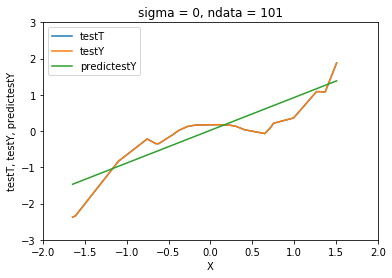

Testing MSE: MSEtestY =

[0.19733787]


In [4]:
# X has incremental values from -5 to 5
# a step of 0.1 corresponds to ndata=101 datapoints
# trying these values for number of datapoints
ndataValues  = [101]
# trying these values for noise's std-dev
sigmaValues  = [0]
#
MSEtestY = question2(ndataValues,sigmaValues)
print('Testing MSE: MSEtestY =\n')
for line in MSEtestY:
    print(*line)


### Question 2.b:

Note that all plots are produced on standardized scale. This provides a generalized overview that can apply to any dataset interval since it can be brought to the standardized interval centered around mean 0 and of standard deviation 1.

Note that testing values for testing output $t$ (testT, with noise), true testing output $y$ (testY, without noise since its variance = 0), and the testing prediction output $\hat{y}$ (predicTestY) are plotted versus 1-D testing features $x$ (testX). Note that $y$ is the truth that the regression model aims to fit to. In 1-D features x, a step of 0.1 in interval $[-5,5]$ corresponds to a total number train/validate/test datapoints ndata = 101. Plots are produced for each noise standard deviations $\sigma = 0,0.1,0.2,0.5,1$ in the measured outputs $t$.

The code determines in each case the best basis function (among the three basis choices), corresponding to a best value of $\lambda^*$ that results in the lowest testing mean squared error for the predicted output (MSEtestY). A linear basis function is generally selected with regularization parameter $\lambda^*=0$. It is noted that the regression function is capable of approximating the true output $y$ (in part 2.a) even with noisy measurements.


***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  0
Corresponding Minimum Value of MSEvallambda:  [0.39364633]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.39364633]), 0.1: array([0.39426573]), 0.3: array([0.3955172]), 0.5: array([0.39678513]), 1: array([0.40002376]), 3: array([0.4138348]), 5: array([0.42872561]), 10: array([0.4687676])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [1.42723932]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([1.49393161]), 0.1: array([1.4928718]), 0.3: array([1.49078731]), 0.5: array([1.48874852]), 1: array([1.48384268]), 3: array([1.46662671]), 5: array([1.4525741]), 10: array([1.42723932])}
***************************************************
************

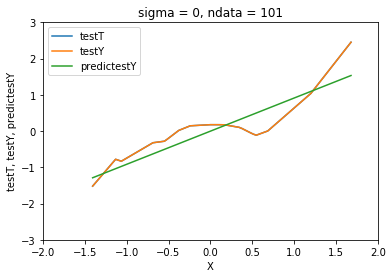

***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  0
Corresponding Minimum Value of MSEvallambda:  [0.3159328]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.3159328]), 0.1: array([0.31650231]), 0.3: array([0.31766307]), 0.5: array([0.31885204]), 1: array([0.32194154]), 3: array([0.33573234]), 5: array([0.35127803]), 10: array([0.39446696])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [1.40488975]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([1.57502879]), 0.1: array([1.57109427]), 0.3: array([1.56352269]), 0.5: array([1.55632402]), 1: array([1.53979285]), 3: array([1.48937471]), 5: array([1.45522614]), 10: array([1.40488975])}
***************************************************
*********

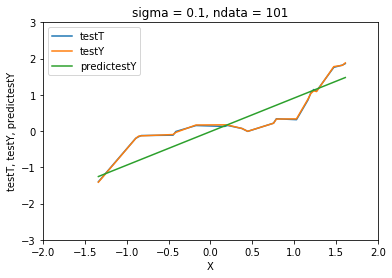

***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  0
Corresponding Minimum Value of MSEvallambda:  [0.3478003]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.3478003]), 0.1: array([0.34855095]), 0.3: array([0.35006921]), 0.5: array([0.35160944]), 1: array([0.3555512]), 3: array([0.37243251]), 5: array([0.39067002]), 10: array([0.43949023])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [1.51135175]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([1.54271409]), 0.1: array([1.54219789]), 0.3: array([1.54118625]), 0.5: array([1.54020118]), 1: array([1.53784707]), 3: array([1.52971993]), 5: array([1.52316888]), 10: array([1.51135175])}
***************************************************
**********

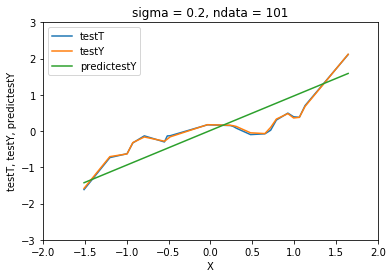

***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  0
Corresponding Minimum Value of MSEvallambda:  [0.32219149]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.32219149]), 0.1: array([0.32280594]), 0.3: array([0.32404794]), 0.5: array([0.32530684]), 1: array([0.32852387]), 3: array([0.34223044]), 5: array([0.35692465]), 10: array([0.39578924])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [1.23206797]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([1.36757939]), 0.1: array([1.36507331]), 0.3: array([1.36018666]), 0.5: array([1.35546042]), 1: array([1.3442968]), 3: array([1.30725041]), 5: array([1.27913386]), 10: array([1.23206797])}
***************************************************
********

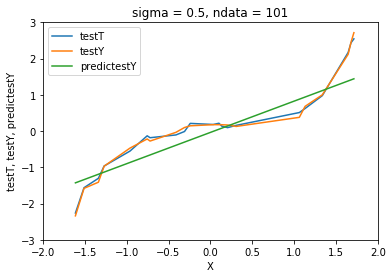

***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  0
Corresponding Minimum Value of MSEvallambda:  [0.3425574]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.3425574]), 0.1: array([0.34321309]), 0.3: array([0.34454052]), 0.5: array([0.34588879]), 1: array([0.34934619]), 3: array([0.36424275]), 5: array([0.38045626]), 10: array([0.42425567])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [1.3609584]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([1.46297566]), 0.1: array([1.46065573]), 0.3: array([1.45617581]), 0.5: array([1.45189823]), 1: array([1.4420115]), 3: array([1.41143429]), 5: array([1.39061609]), 10: array([1.3609584])}
***************************************************
************

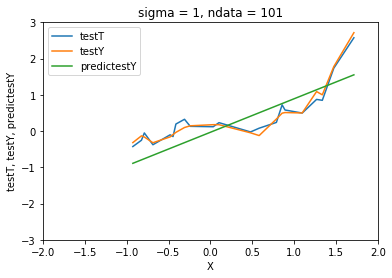

Testing MSE: MSEtestY =

[0.1403188] [0.14942895] [0.1894323] [0.26536478] [0.22429623]


In [5]:
# X has incremental values from -5 to 5
# trying these values for number of datapoints
ndataValues  = [101]
# trying these values for noise's std-dev
sigmaValues  = [0, 0.1, 0.2, 0.5, 1]
#
MSEtestY = question2(ndataValues,sigmaValues)
print('Testing MSE: MSEtestY =\n')
for line in MSEtestY:
    print(*line)


### Question 2.c:

Note that all plots are produced on standardized scale. This provides a generalized overview that can apply to any dataset interval since it can be brought to the standardized interval centered around mean 0 and of standard deviation 1.

An experiment is run to determine how close the regression model is to the true testing output based on the number of training data $[4,5,10,20,50,101,200,500]$ and the variance of the noise $[0, 0.1, 0.2, 0.5, 1]$.

A table that has the number of training data in the rows and the standard deviations in the columns is presented below. It report the cross-validation squared error when the regression function with K-fold cross validation is run on each of the 32 combinations of parameters stated above.

It is noted from the results that mean squared error on testing data increases with more noise and decreases with more datapoints.

In [6]:
# X has incremental values from -5 to 5
# note that having only 2 or 3 datapoints results in singular matrix when
# estimating model using w = estimate_model(Ttrain,Phi,lambda_reg)
# trying these values for number of datapoints
ndataValues  = [4,5,10,20,50,101,200,500]
# trying these values for noise's std-dev
sigmaValues  = [0, 0.1, 0.2, 0.5, 1]
#
MSEtestY = question2(ndataValues,sigmaValues)
# clear cell output
clear_output()
#
print('Testing MSE: MSEtestY =\n')
for line in MSEtestY:
    print(*line)


Testing MSE: MSEtestY =

[0.45397926] [5.12482739] [5.37142817] [5.10974426] [0.46598077]
[0.45288836] [3.61088185] [4.11199423] [3.65773236] [2.12510936]
[0.19421212] [0.12386125] [0.26946137] [0.68058122] [0.21417179]
[0.38319769] [0.28036767] [0.49750865] [0.34449528] [0.21616056]
[0.16502025] [0.31338997] [0.18807534] [0.18244383] [0.21978456]
[0.21896396] [0.25130496] [0.15931156] [0.18201314] [0.10330471]
[0.17234862] [0.17081981] [0.15505036] [0.16079499] [0.17392752]
[0.17629493] [0.1784651] [0.181107] [0.16429902] [0.21520437]


### Question 2.d:

Note that all plots are produced on standardized scale. This provides a generalized overview that can apply to any dataset interval since it can be brought to the standardized interval centered around mean 0 and of standard deviation 1.

The two best results (with lowest testing MSE) and two worst results (with highest testing MSE) are selected based on paramters in part 2.c, and four plots are produced. Note that testing values for testing output $t$ (testT, with noise), true testing output $y$ (testY, without noise since its variance = 0), and the testing prediction output $\hat{y}$ (predicTestY) are plotted versus 1-D testing features $x$ (testX). Note that $y$ is the truth that the regression model aims to fit to.

It is noted from the results that mean squared error on testing data increases with more noise and decreases with more datapoints.

In [7]:
# make plots for a sufficient number ndata of train/validate/test data points
# note that having only 2 or 3 datapoints results in singular matrix when
# estimating model using w = estimate_model(Ttrain,Phi,lambda_reg)
# trying these values for number of datapoints
ndataValues  = [20,50,101,200,500]
# trying these values for noise's std-dev
sigmaValues  = [0, 0.1, 0.2, 0.5, 1]
#
MSEtestY = question2(ndataValues,sigmaValues)
# clear cell output
clear_output()
#

max1 =
 [0.29098207]
max2 =
 [0.25417344]
min1 =
 [0.04451404]
min2 =
 [0.06736709]
***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  0
Corresponding Minimum Value of MSEvallambda:  [0.37796907]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.37796907]), 0.1: array([0.37954182]), 0.3: array([0.38274548]), 0.5: array([0.38602243]), 1: array([0.39450415]), 3: array([0.43145788]), 5: array([0.47107732]), 10: array([0.571161])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [1.60184639]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([1.67752721]), 0.1: array([1.67596878]), 0.3: array([1.67294252]), 0.5: array([1.67003114]), 1: array([1.66321411]), 3: array([1.64122449]), 5: array([1.62536518]), 10

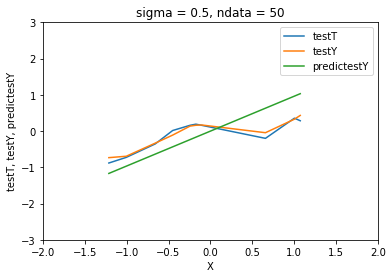

Above plot is for worst performance: first max value found for MSEtestY:

Note that MSE value changes as a new testX is generated at each code run
***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  0
Corresponding Minimum Value of MSEvallambda:  [0.44949665]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.44949665]), 0.1: array([0.4525341]), 0.3: array([0.45899316]), 0.5: array([0.46588748]), 1: array([0.48452933]), 3: array([0.56639894]), 5: array([0.64474356]), 10: array([0.79990345])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [1.42683195]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([2.44769046]), 0.1: array([2.3795631]), 0.3: array([2.26463123]), 0.5: array([2.17122325]), 1: array([1

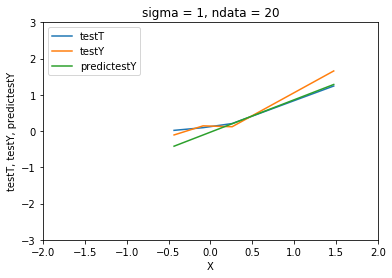

Above plot is for worst performance: second max value found for MSEtestY:

Note that MSE value changes as a new testX is generated at each code run
***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  0
Corresponding Minimum Value of MSEvallambda:  [0.38497057]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.38497057]), 0.1: array([0.38648356]), 0.3: array([0.38956727]), 0.5: array([0.39272345]), 1: array([0.4008983]), 3: array([0.43651367]), 5: array([0.47457391]), 10: array([0.56989907])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [1.57321449]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([1.7308423]), 0.1: array([1.72737074]), 0.3: array([1.72067472]), 0.5: array([1.71428778]), 1: array([

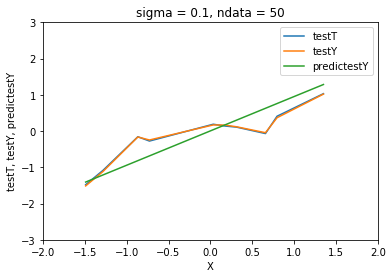

Above plot is for best performance: first min value found for MSEtestY
Note that MSE value changes as a new testX is generated at each code run
***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  0
Corresponding Minimum Value of MSEvallambda:  [0.25856947]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.25856947]), 0.1: array([0.26328713]), 0.3: array([0.27326532]), 0.5: array([0.28384316]), 1: array([0.31212568]), 3: array([0.43245091]), 5: array([0.5435901]), 10: array([0.75619305])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [1.48176405]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([1.9974989]), 0.1: array([1.95865028]), 0.3: array([1.894583]), 0.5: array([1.84380827]), 1: array([1.7530

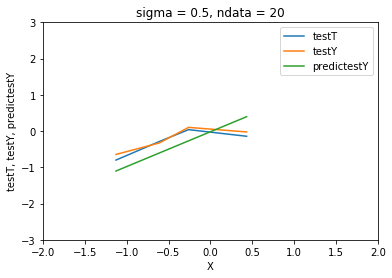

Above plot is for best performance: second min value found for MSEtestY
Note that MSE value changes as a new testX is generated at each code run


In [8]:
# indices for worst performance: first and second max values for MSEtestY
# note that each element in 3d-array MSETestY has 'nouputs' elements
# create copy of MSEtestY
a          = np.copy(MSEtestY)
# find indices for first max value for MSEtestY, this returns 3 indices for 3d-array
indmax1    = np.unravel_index(np.nanargmax(a, axis=None), a.shape)
# set elements of this value to np.nan afterwards, nanargmax will then ignore it
print('max1 =\n',a[indmax1[0],indmax1[1],:])
a[indmax1[0],indmax1[1],:] = np.nan
# find indices for second max value for MSEtestY, this returns 3 indices for 3d-array
indmax2    = np.unravel_index(np.nanargmax(a, axis=None), a.shape)
# set this value to np.nan afterwards
print('max2 =\n',a[indmax2[0],indmax2[1],:])
a[indmax2[0],indmax2[1],:] = np.nan
# indices for best performance: first and second min values for MSEtestY
# create copy of MSEtestY
# a          = np.copy(MSEtestY)
# find indices for first min value for MSEtestY, this returns 3 indices for 3d-array
indmin1    = np.unravel_index(np.nanargmin(a, axis=None), a.shape)
# set this value to np.nan afterwards, nanargmin will then ignore it
print('min1 =\n',a[indmin1[0],indmin1[1],:])
a[indmin1[0],indmin1[1],:] = np.nan
# find indices for second min value for MSEtestY, this returns 3 indices for 3d-array
indmin2    = np.unravel_index(np.nanargmin(a, axis=None), a.shape)
# set this value to np.nan afterwards
print('min2 =\n',a[indmin2[0],indmin2[1],:])
a[indmin2[0],indmin2[1],:] = np.nan
# print('a =\n', a)
# print('MSEtestY =\n', MSEtestY)
#
#
# worst performance: first max value found for MSEtestY
foundndataValues = [ndataValues[indmax1[0]]]
foundsigmaValues = [sigmaValues[indmax1[1]]]
# re-running the code in order to generate the plots; note 
# that MSE value for testY will change as testY is changed at each code run
MSEtestY = question2(foundndataValues,foundsigmaValues)
print('Above plot is for worst performance: first max value found for MSEtestY:\n')
print('Note that MSE value changes as a new testX is generated at each code run')
# print('MSEtestY =\n',MSEtestY)
#
# worst performance: second max value found for MSEtestY
foundndataValues = [ndataValues[indmax2[0]]]
foundsigmaValues = [sigmaValues[indmax2[1]]]
# re-running the code in order to generate the plots; note 
# that MSE value for testY will change as testY is changed at each code run
MSEtestY = question2(foundndataValues,foundsigmaValues)
print('Above plot is for worst performance: second max value found for MSEtestY:\n')
print('Note that MSE value changes as a new testX is generated at each code run')
# print('MSEtestY =\n',MSEtestY)
#
# best performance: first min value found for MSEtestY
foundndataValues = [ndataValues[indmin1[0]]]
foundsigmaValues = [sigmaValues[indmin1[1]]]
# re-running the code in order to generate the plots; note 
# that MSE value for testY will change as testY is changed at each code run
MSEtestY = question2(foundndataValues,foundsigmaValues)
print('Above plot is for best performance: first min value found for MSEtestY')
print('Note that MSE value changes as a new testX is generated at each code run')
# print('MSEtestY =\n',MSEtestY)
#
# best performance: second min value found for MSEtestY
foundndataValues = [ndataValues[indmin2[0]]]
foundsigmaValues = [sigmaValues[indmin2[1]]]
# re-running the code in order to generate the plots; note 
# that MSE value for testY will change as testY is changed at each code run
MSEtestY = question2(foundndataValues,foundsigmaValues)
print('Above plot is for best performance: second min value found for MSEtestY')
print('Note that MSE value changes as a new testX is generated at each code run')
# print('MSEtestY =\n',MSEtestY)


## Question 3:

The algorithm for regression with K-fold cross validation is run for the three UCI data sets introduced in the description. Note that the algorithm is run 10 times to provide estimates of the testing mean squared error (MSEtestY) of the learned model for each dataset. The obtained testing mean squared error for several runs of K-fold cross-validation for each data set are presented. The code execution output with details is separated on the appendix for the reader to review.

The testing MSE's for the "Airfoil Self-Noise" obtained in multiple runs stay around the same values which are low. This shows the algorithm's accuracy is good for this dataset. Note that for this dataset, a degree M=2 polynomial basis function is generally selected by the algorithm with regularization parameter $\lambda^*\neq0$, which results in a minimal testing MSE.

The testing MSE's for the "Yacht Hydrodynamics" obtained in multiple runs stay around the same values which are very low. This shows the algorithm's accuracy is very good for this dataset. Note that for this dataset, a degree M=2 polynomial basis function is generally selected by the algorithm with regularization parameter $\lambda^*\neq0$, which results in a minimal testing MSE.

The testing MSE's for the "Concrete Slump" obtained in multiple runs stay around the same values (which are very low) for the last output, but varies slightly for the first and second outputs although within an acceptable margin. This shows the algorithm's accuracy is acceptable for this dataset, but a better algorithm ought to be implemented. Note that for this dataset, a linear basis function is generally selected by the algorithm with regularization parameter $\lambda^*\neq0$, which results in a minimal testing MSE.

The results for the testing MSE are reasonable and close to the instructor's results. It is noted that in the two first datasets, a degree M=2 polynomial basis performed better than the linear basis function prediction. This is an exception only so long as the polynomial's degree is kept low at M=2. If the polynomial's degree is increased, the linear basis functions start performing better than the polynomial basis functions.


In [9]:
def question3(allData,noutputs):
    # this function answers question 3
    # allData is all datapoints (training/validation and testing)
    # returns MSE for prediction testY of testing data testX
    # present mean squared error for several cross-validation folds by
    # re-running the algorithm 10 times for each data set
    runs     = 10
    MSEtestY = np.ones((runs, noutputs))
    for r in range(0,runs):
        # last 'noutputs' columns of allData are for outputs / measurements T
        T          = allData[:,-noutputs:]
        # remaining columns of allData are for features
        X          = allData[:,:-noutputs]
        #
        # z-score: STANDARDIZATION SHOULD BE DONE ON ENTIRE SET (TRAINING/VALIDATION U TESTING)
        # STANDARDIZATION is done before/outside each my_Regression function call
        # standardize training/validation features Xdata, outputs Tdata, testing features testX
        # by subtracting by the mean of each column of the data and 
        # dividing by the standard deviation of each column of the data
        # resulting sets will have columns with means of 0 and st-devs of 1
        X = scale(X)
        T = scale(T)
        # Y = scale(Y)
        #
        # testX and trainX should be selected carefully to avoid getting non-representative samples
        # RANDOMLY select 20% of data for testing (in testX) and 80% of data for training/validation (in trainX)
        (ndata,c) = X.shape
        ntest     = np.ceil(20/100*ndata).astype('int')
        # for sampling without duplicates, use random.sample; to choose with replacement, use random.choices
        data_idx  = range(0,ndata)
        testX_idx = random.sample(data_idx, k=ntest)
        testX_idx.sort()
        # Use 'set' to remove elements of one list from another; it has the fastest performance
        # however, note that 'set' removes duplicates and doesn't keep the order of elements
        trainX_idxset = set(data_idx) - set(testX_idx)
        trainX_idx    = list(trainX_idxset)
        trainX_idx.sort()
        # trainX contains both X and T=Y+noise for training/validation
        # concatenate 2 numpy arrays: column-wise by specifying axis=1
        trainX = np.concatenate((X[trainX_idx,:],T[trainX_idx,:]),axis=1)
        # testX contains only X for testing
        testX  = X[testX_idx,:]
        # testY is ALMOST NEVER known since only T=Y+noise is given
        # testY  = Y[testX_idx,:]
        testT  = T[testX_idx,:]
        #
        predictestY       = my_regression(trainX,testX,noutputs)
        # following syntaxe works for any number of outputs
        MSEtestY[r,:]     = np.mean((np.power((testT - predictestY),2)), axis=0) # column-wise: axis=0
        #
        """
        print('Training/Validation data indices = ',trainX_idx)
        print('Testing data indices = ',testX_idx)
        print('Training/Validation data [X,T] trainX =\n',trainX)
        print('Testing data [X] testX =\n',testX)
        print('Labeled testing outputs testT =\n',testT)
        """
        print('***************************************************')
        print('Predicted outputs Y (for testing data testX) predictestY =\n',predictestY)
        print('Testing Mean Square Error for Y MSEtestY =\n',MSEtestY[r,:])
        print('***************************************************')
        # wait for keypress
        # input("Press Enter to continue...")
        """
        plt.plot(testX,testT,testX,predictestY)
        plt.xlabel('X')
        plt.ylabel('testT, predictestY')
        plt.legend(['testT','predictestY'])
        plt.title('Results for dataset: '+str(datasetname))
        plt.show()
        """
    #
    return MSEtestY


In [10]:
datasetname1  = 'airfoil_self_noise.dat'
noutputs      = 1
allData       = np.loadtxt(datasetname1)
MSEtestY_set1 = question3(allData,noutputs)
#
#
datasetname2  = 'yacht_hydrodynamics.data'
noutputs      = 1
allData       = np.loadtxt(datasetname2)
MSEtestY_set2 = question3(allData,noutputs)
#
#
datasetname3  = 'slump_test.data'
noutputs      = 3
allData       = np.loadtxt(datasetname3, delimiter=',', skiprows=1)
MSEtestY_set3 = question3(allData,noutputs)
#
#
# clear cell output: the details of the above execution are shown in the appendix
clear_output()
#
#
print('***************************************************')
print('***************************************************')
print('Dataset Name = ',datasetname1)
print('Testing Mean Square Error for Y MSEtestY =\n',MSEtestY_set1)
print('***************************************************')
print('***************************************************')
# wait for keypress
# input("Press Enter to continue...")

print('***************************************************')
print('***************************************************')
print('Dataset Name = ',datasetname2)
print('Testing Mean Square Error for Y MSEtestY =\n',MSEtestY_set2)
print('***************************************************')
print('***************************************************')
# wait for keypress
# input("Press Enter to continue...")

print('***************************************************')
print('***************************************************')
print('Dataset Name = ',datasetname3)
print('Testing Mean Square Error for Y MSEtestY =\n',MSEtestY_set3)
print('***************************************************')
print('***************************************************')
# wait for keypress
# input("Press Enter to continue...")


***************************************************
***************************************************
Dataset Name =  airfoil_self_noise.dat
Testing Mean Square Error for Y MSEtestY =
 [[0.47367049]
 [0.36185686]
 [0.39434319]
 [0.42229173]
 [0.31797967]
 [0.36327867]
 [0.33634361]
 [0.3625328 ]
 [0.31200191]
 [0.39376711]]
***************************************************
***************************************************
***************************************************
***************************************************
Dataset Name =  yacht_hydrodynamics.data
Testing Mean Square Error for Y MSEtestY =
 [[0.13314037]
 [0.06573616]
 [0.08590282]
 [0.06924517]
 [0.09183189]
 [0.08127051]
 [0.07104604]
 [0.09812364]
 [0.07796143]
 [0.05990708]]
***************************************************
***************************************************
***************************************************
***************************************************
Dataset Name =  slump_test.dat

## Appendix: Question 3 Execution Ouput Details

**** page left intentionally blank ****

<div style=”page-break-after: always;”></div>

In [11]:
# Gives details of the execution output for question 3
#
datasetname1  = 'airfoil_self_noise.dat'
noutputs      = 1
allData       = np.loadtxt(datasetname1)
print('***************************************************')
print('***************************************************')
print('Dataset Name = ',datasetname1)
MSEtestY_set1 = question3(allData,noutputs)
print('Dataset Name = ',datasetname1)
print('Testing Mean Square Error for Y MSEtestY =\n',MSEtestY_set1)
print('***************************************************')
print('***************************************************')
# wait for keypress
# input("Press Enter to continue...")
#
#
datasetname2  = 'yacht_hydrodynamics.data'
noutputs      = 1
allData       = np.loadtxt(datasetname2)
print('***************************************************')
print('***************************************************')
print('Dataset Name = ',datasetname2)
MSEtestY_set2 = question3(allData,noutputs)
print('Dataset Name = ',datasetname2)
print('Testing Mean Square Error for Y MSEtestY =\n',MSEtestY_set2)
print('***************************************************')
print('***************************************************')
# wait for keypress
# input("Press Enter to continue...")
#
#
datasetname3  = 'slump_test.data'
noutputs      = 3
allData       = np.loadtxt(datasetname3, delimiter=',', skiprows=1)
print('***************************************************')
print('***************************************************')
print('Dataset Name = ',datasetname3)
MSEtestY_set3 = question3(allData,noutputs)
print('Testing Mean Square Error for Y MSEtestY =\n',MSEtestY_set3)
print('***************************************************')
print('***************************************************')
# wait for keypress
# input("Press Enter to continue...")


***************************************************
***************************************************
Dataset Name =  airfoil_self_noise.dat
***************************************************
Basis Name:  linear
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [0.56785193]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.56912181]), 0.1: array([0.56910573]), 0.3: array([0.56907378]), 0.5: array([0.56904213]), 1: array([0.56896428]), 3: array([0.56867068]), 5: array([0.56840462]), 10: array([0.56785193])}
***************************************************
***************************************************
Basis Name:  polynomial
Lambda for Minimum Value of MSEvallambda:  10
Corresponding Minimum Value of MSEvallambda:  [0.52087212]
All Recordings for lambda and MSE validation errors MSEvalDict =
 {0: array([0.54297502]), 0.1: array([0.5425058]), 0.3: array([0.54162153]), 0.5: array([0.54080066]), 1: array([0.5